In [30]:
# torch.nn.functional中有很多功能，后续会常用。那么什么是用nn.Module，什么时候用nn.functional呢
# 一般情况下，如果 模型有可学习的参数，最好用nn.Module，其他情况用nn.functional更简单一些
# MSB:可以认为是大端存储
# python中的...省略号,表示索引操作时省略冒号 a[:,:,1] = a[...,1]


In [ ]:
'''
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  10000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  10000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).
'''

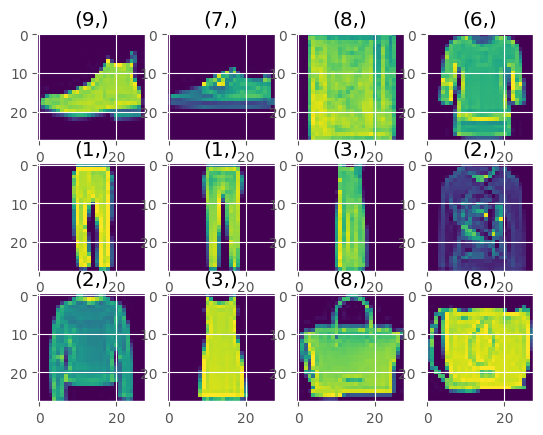

In [36]:
%matplotlib inline
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt

# data_name = 'd:/GitRepos/data/{}/train-images-idx3-ubyte.gz'.format('MNIST')

mnist = {
    'trainset'  :'d:/GitRepos/data/MNIST/train-images-idx3-ubyte.gz',
    'trainlabel':'d:/GitRepos/data/MNIST/train-labels-idx1-ubyte.gz',
    'testset'   :'d:/GitRepos/data/MNIST/t10k-images-idx3-ubyte.gz',
    'testlabel' :'d:/GitRepos/data/MNIST/t10k-labels-idx1-ubyte.gz'
}
fashion_mnist = {
    'trainset'  :'d:/GitRepos/data/fashionMNIST/train-images-idx3-ubyte.gz',
    'trainlabel':'d:/GitRepos/data/fashionMNIST/train-labels-idx1-ubyte.gz',
    'testset'   :'d:/GitRepos/data/fashionMNIST/t10k-images-idx3-ubyte.gz',
    'testlabel' :'d:/GitRepos/data/fashionMNIST/t10k-labels-idx1-ubyte.gz'
}

image_header = {
    'magic' :0,
    'cnt'   :0,
    'rows'  :0,
    'cols'  :0
}
label_header = {
    'magic'  :0,
    'itemNum':0
}

def get_header_idx(path : str,header_fmt : str):
    offset = 0
    # fmt = '>{}i'.format(head_size)
    with gzip.open(path) as f:
        bytescontent = f.read()
        h_list = [x for x in struct.unpack_from(header_fmt,bytescontent,offset=offset)]
        keys   = [k for k in image_header.keys()]
        header = dict(zip(keys,h_list))
    return header

def image_loader_idx3(path : str,header_fmt : str,header : dict,yield_batch_idx : int,yield_batch_size : int):
    '''
    offset : starting position in byte
    format : asigning number of bytes to read
    '''
    # 
    assert yield_batch_idx  > 0
    assert yield_batch_size > 0
    # header offset,use struct.calcsize() to get the correct offset caused by aligning
    offset_head = struct.calcsize(header_fmt)
    size_image = header['rows'] * header['cols']
    # batch offset
    fmt_batch = '{}B'.format((yield_batch_idx-1) * yield_batch_size * size_image)
    offset_batch = struct.calcsize(fmt_batch)
    # single image offset
    fmt_image = '>{}B'.format(size_image)
    with gzip.open(path) as f:
        bindata = f.read()
        images_list = (
            np.array(
            struct.unpack_from(
                fmt_image,
                bindata,
                offset= struct.calcsize(fmt_image) * i + offset_head + offset_batch
                )
            ).reshape(header['rows'],header['cols'])
            for i in range(yield_batch_size)
        )
    return images_list

def label_loader_idx1(path : str,header_fmt : str,yield_batch_idx : int,yield_batch_size : int):
    #
    assert yield_batch_idx  > 0
    assert yield_batch_size > 0
    # head offset
    offset_head = struct.calcsize(header_fmt)
    # batch offset
    fmt_batch = '{}B'.format((yield_batch_idx - 1) * yield_batch_size * 1)
    offset_batch = struct.calcsize(fmt_batch)
    fmt = '>B'
    with gzip.open(path) as f:
        bindata = f.read()
        labels_list =(
            struct.unpack_from(
            fmt,
            bindata,
            offset=offset_head + struct.calcsize(fmt) * i + offset_batch
            )
            for i in range(yield_batch_size)
        )
    return labels_list

def compress_as_gzip(inpath : str,outpath : str):
    '''
    open a non-GZip file, compress and save with extension .gz
    '''
    with open(inpath,'rb') as f:
        bindata = f.read()
        gobj = gzip.GzipFile(
            filename=inpath,
            mode='wb',
            compresslevel=9,
            fileobj=open(outpath,mode='wb')
        )
        gobj.write(bindata)

# asigning data path
m_data = mnist
image_header = get_header_idx(path=m_data['trainset'],header_fmt='>4i')
label_header = get_header_idx(path=m_data['trainlabel'],header_fmt='>2i' )

# asigning batch position and size
yield_batch_idx = 50
yield_batch_size = 100

# form a new header
header_fmt_image = '>4i'
header_fmt_label = '>2i'

# load data
train_image_loader = image_loader_idx3(path=m_data['trainset'],header_fmt=header_fmt_image,header=image_header,yield_batch_idx=yield_batch_idx,yield_batch_size=100)
train_label_loader = label_loader_idx1(path=m_data['trainlabel'],header_fmt=header_fmt_label,yield_batch_idx=yield_batch_idx,yield_batch_size=100)

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
# print(list(image_loader)[0].shape, plt.style.available)

# show data
plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=3,ncols=4)
for ax in axs:
    for a in ax:
        a.set_title('{}'.format(next(train_label_loader)))
        a.imshow(next(train_image_loader))



In [33]:
import torch

# [compress_as_gzip(fashion_mnist[k],fashion_mnist[k]+'.gz') for k in fashion_mnist.keys()]

[None, None, None, None]